In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
from argparse import ArgumentParser
import sqlite3
from os import path
import pandas as pd

class Filter:
    guide_keywords = ['book', 'guide', 'synthes', 'manufacture', 'homemade', 'bundle', 'how to', 'tutorial', 'manual']

    @staticmethod
    def filter_custom_listings(df):
        custom_listings = df[
            df.title.str.lower().str.contains('custom')
        ]

        item_hashes = custom_listings.groupby('item_hash').filter(lambda x: len(x) <= 1)
        return df[~df.item_hash.isin(item_hashes['item_hash'])]

    @staticmethod
    def filter_drug_listings(dfItems):
        drug_keywords = [
            'alprazolam', 'hulk', 'percocet', 'pfizer', 'tavor', '0mg', '0 mg', '5mg', '5 mg', '0ug', '0 ug', 
            '5ug', '5 ug', 'µ', 'glue', 'preroll', 'pre-roll', 'ferrari', 'tesla', 'calvin klein', 'methyl', 
            'kush', 'amphetamine', 'mdma', '4fa', 'viagra', 'captagon', 'blotter', 'pill', 'microdot', '2c-', 
            'ambien', 'olam', 'epam', 'blunt', 'fentanyl', 'pvp', 'oxycodone', 'xanax', 'tablets'
        ]

        df_guide_items = dfItems[dfItems['title'].str.lower().str.contains('|'.join(Filter.guide_keywords))]

        df_drug_related_items = dfItems[dfItems['title'].str.lower().str.contains('|'.join(drug_keywords))]
        df_drug_items = df_drug_related_items[~df_drug_related_items.index.isin(df_guide_items.index)]

        return dfItems[~dfItems.index.isin(df_drug_items.index)]

    @staticmethod
    def filter_misc(df):
        misc_keywords = ['tip jar', 'cyanid']

        df_misc_items = df[df['title'].str.lower().str.contains('|'.join(misc_keywords))]

        return df[~df.index.isin(df_misc_items.index)]

    @staticmethod
    def filter_guns(df):
        df_guide_items = df[df['title'].str.lower().str.contains('|'.join(Filter.guide_keywords))]
        
        gun_keywords = [
            'magnum', 'glock', 'stungun', 'stun gun', 'airsoft', 'ammunition', 'rounds'
        ]

        df_gun_items = df[df['title'].str.lower().str.contains('|'.join(gun_keywords)) | df['description'].str.lower().str.contains('|'.join(gun_keywords))]
        df_exclude = df_gun_items[~df_gun_items.index.isin(df_guide_items.index)]

        return df[~df.index.isin(df_exclude.index)]

    @staticmethod
    def separate_carding(df):
        carding_keywords = [
            'cvv', 'fullz', 'fulls', 'carding', 'vbv', 'avs', 'visa', 'mastercard', 'amex', 'ccv', 'pizza', 'slice', ' cc '
        ]

        non_carding_indicators = [
            'vps', 'rdp', 'anonymous', 'anon', 'reloadable', 'server'
        ]

        carding_categories = [
            'cash-out', 'other - account', 'other - guide', 'other'
        ]

        df_carding_items = df[(df['category'].isin(carding_categories)) & (df['title'].str.lower().str.contains('|'.join(carding_keywords)))]
        df_carding_items = df_carding_items[~df_carding_items['title'].str.lower().str.contains('|'.join(non_carding_indicators))]

        df.loc[df.index.isin(df_carding_items.index), 'category'] = 'carding'
        
        return df

    @staticmethod
    def apply_all_filters(df):
        print(f"Size before filter: {df.shape[0]}")

        df = Filter.filter_custom_listings(df)
        print(f"Size after filtering custom listing: {df.shape[0]}")

        df = Filter.filter_drug_listings(df)
        print(f"Size after filtering drugs: {df.shape[0]}")

        df = Filter.filter_misc(df)
        print(f"Size after filtering misc: {df.shape[0]}")

        df = Filter.filter_guns(df)
        print(f"Size after filtering guns: {df.shape[0]}")

        df = Filter.separate_carding(df)

        return df

def load_dataset(location):
    connection = sqlite3.connect(location)

    df = pd.read_sql("SELECT * FROM feedbacks left join items on feedbacks.item_hash = items.item_hash", connection)
    # remove duplicated columns
    df = df.loc[:, ~df.columns.duplicated()]
    # convert bytestrings
    df['giver_hash'] = df['giver_hash'].str.decode("utf-8")
    df['receiver_hash'] = df['receiver_hash'].str.decode("utf-8")
    df['vendor_hash'] = df['vendor_hash'].str.decode("utf-8")
    # convert timestamps
    df['date'] = pd.to_datetime(df['date'])
    df['first_observed'] = pd.to_datetime(df['first_observed'])
    df['last_observed'] = pd.to_datetime(df['last_observed'])
    # close connection
    connection.close()

    return df

df = load_dataset('../../data/underground_cyber.sqlite3')
df = Filter.apply_all_filters(df)

Size before filter: 564204
Size after filtering custom listing: 560002
Size after filtering drugs: 544942
Size after filtering misc: 542799
Size after filtering guns: 541419


In [185]:
# Total revenue per month
# df_rev = df[df['marketplace'] == 'Alphabay']
df_rev = df.copy()
df_rev = df_rev[['date', 'total_sales']]
df_rev['date'] = pd.DatetimeIndex(df_rev['date']).to_period('M')
df_rev = df_rev.sort_values(by='date')
df_rev_bydate = df_rev.groupby('date').sum()
df_rev_bydate

,total_sales
date,
2011-06,1.312900e+03
2011-07,3.463049e+04
2011-08,2.992740e+05
2011-09,6.294461e+05
2011-10,4.636198e+05
...,...
2017-01,1.259526e+08
2017-02,1.500545e+08
2017-03,1.577099e+08


In [191]:
# title:("black market*") OR ("underground market*") OR ("dark net market*") OR  ("darkweb market*"~10) OR ("cryptomarket") OR ("tor market*"~10) OR ("darknet market*"~10) OR ("silk road") OR ("alphabay") OR ("silk road 2") NOT ("belt road"~10)

df_media = pd.read_csv('../../data/title-black-market-or-stories-over-time-20201022110708.csv')[['date', 'count']]
df_media['date'] = pd.to_datetime(df['date'])
df_media = df_media.sort_values(by='date').reset_index(drop=True).dropna()
df_media['date'] = pd.DatetimeIndex(df_media['date']).to_period('M')
df_media_bydate = df_media.groupby('date').sum()
df_media_bydate

,count
date,
2011-09,326
2011-10,348
2011-11,301
2011-12,663
2012-01,845
...,...
2017-01,1874
2017-02,1253
2017-03,1987


In [ ]:
df_tor = pd.read_csv('../../data/webstats-tb-2013-01-01-2017-12-31.csv')[['date', 'initial_downloads']]
df_tor['date'] = pd.to_datetime(df_tor['date'])
df_tor = df_tor.sort_values(by='date').reset_index(drop=True).dropna()
df_tor['date'] = pd.DatetimeIndex(df_tor['date']).to_period('M')
df_tor_bydate = df_tor.groupby('date').sum()
df_tor_bydate = df_tor_bydate[df_tor_bydate.index.isin(df_media_bydate.index)]
df_tor_bydate

In [192]:
df_corr = df_media_bydate.merge(df_rev_bydate, on='date')
# df_corr['sales'] = df_rev_bydate['total_sales']
df_corr.corr(method='kendall')

,count,total_sales
count,1.000000,0.327513
total_sales,0.327513,1.000000


0.3275132733564705 0.00016991651537995867


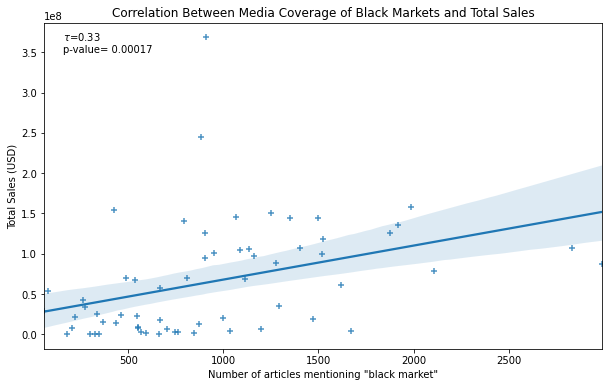

In [193]:
from scipy import stats
from seaborn import regplot
import matplotlib.pyplot as plt
x = df_corr['count'].tolist()
y = df_corr['total_sales'].tolist()
corr, p_value = stats.kendalltau(x, y)
print(corr, p_value)
plt.figure(figsize=(10,6))
ax = regplot(x=x, y=y, marker="+")
ax.set(xlabel='Number of articles mentioning "black market"', ylabel='Total Sales (USD)', title='')

ax.set_title('Correlation Between Media Coverage of Black Markets and Total Sales')
ax.text(min(x)+max(x)/30, max(y)-max(y)/20, r'$\tau$=' + str(round(corr, 2)) + '\np-value= ' + str(round(p_value, 6)))

plt.savefig('mediacoverage_corr.pdf')

plt.show()

In [189]:
df.marketplace.unique()

array(['Alphabay', 'Silk Road 1', 'Evolution', 'Black Market Reloaded',
       'Agora', 'Pandora', 'Hydra', 'Silk Road 2'], dtype=object)

In [190]:
df.date.max()

Timestamp('2017-05-26 00:00:00')